# Otimização de Elenco de Futebol: Uma Abordagem Baseada em Dados

**Disciplina:** Otimização (COS360/COM361) - 2025

**Aluno:** Daniel Rebouças de Sousa Barros

**Professor:** Luidi Simonetti

---

In [92]:
import pandas as pd
import numpy as np
import time
import pulp
import plotly.graph_objects as go

# Configuração e Hiperparâmetros

In [93]:
# 1. Configurações do Ambiente
ANO_REFERENCIA = 2025
ARQUIVO_DADOS_PRINCIPAL = "player-data-full.csv"
ARQUIVO_DADOS_CUSTOM = "flamengo_custom_players.csv"
TIME_ESCOLHIDO = "Flamengo"
LIGA_TIME = "Premier League"
NUM_JANELAS = 4

# --- REPRODUTIBILIDADE ---
# Fixa a semente aleatória. Mude este número para gerar um "universo" diferente.
# Mantendo 42, os resultados serão sempre IDÊNTICOS a cada execução.
RANDOM_SEED = 42 
np.random.seed(RANDOM_SEED)

# 2. Definição dos Modos de Gestão
STRATEGIES = {
    "CONSERVADOR": {
        "desc": "Win Now & Safe: Prioriza veteranos, química alta e muita segurança de caixa.",
        "weights": {"qualidade": 0.95, "potencial": 0.02, "fisico": 0.03},
        "friction": 8.0,
        "decay_quimica": 0.95,
        "budget_factor": 1.0,
        "risk_appetite": 1.0    
    },
    "ARRISCADO": {
        "desc": "Trading Competitivo: Lucrar com vendas, mas manter time titular digno.",
        
        # AJUSTE 1: Rebalanceamento. A Qualidade volta a ser relevante (60%).
        # Antes era 20/80. Agora o solver não vai escalar um OVR 71 no lugar de um 80 
        # só pelo potencial, a menos que a diferença de lucro seja absurda.
        "weights": {"qualidade": 0.60, "potencial": 0.40, "fisico": 0.0},

        # AJUSTE 2: Fricção Leve (2.0).
        # Impede a troca de 100% do time titular de uma vez.
        "friction": 2.0,

        # Química baixa (time muda bastante)
        "decay_quimica": 0.50,
        "budget_factor": 1.3,

        # AJUSTE 3: Apetite por Risco Moderado-Alto (1.0).
        # Baixamos de 2.0 para 1.0. O dinheiro importa, mas não vale "qualquer sacrifício".
        # O modelo vai vender o Pedro se tiver um substituto OVR 79 barato, 
        # mas não se o substituto for OVR 71.
        "risk_appetite": 1.0
    },
    "EQUILIBRADO": {
        "desc": "Realista: Foco em montar o melhor time possível com o dinheiro disponível.",
        "weights": {"qualidade": 0.80, "potencial": 0.15, "fisico": 0.05},

        "friction": 1.5,       # AUMENTADO de 4.0 para 7.0 (Segura um pouco as contratações)
        "decay_quimica": 0.70, # Levemente maior para não zerar química tão rápido
        "budget_factor": 1.0,   # Normalizado
        "risk_appetite": 0.5
    }
}

# --- SELECIONE O MODO AQUI ---
MODO_ATUAL = "EQUILIBRADO"
CFG = STRATEGIES[MODO_ATUAL]

print(f"⚡ MODO SELECIONADO: {MODO_ATUAL}")
print(f"📝 Descrição: {CFG['desc']}")

# 3. Parâmetros Financeiros
TRANSFER_BUDGET_INICIAL = 40.0 * CFG['budget_factor']
PERCENTUAL_FOLGA_SALARIAL = 0.2
VALOR_MAX_JOGADOR = 250.0
TAXAS = {"compra": 0.12, "venda": 0.10, "assinatura": 0.75}

# 4. Parâmetros de Performance
K_MERCADO_POR_POS = 400
K_PARES_POR_JOGADOR = 12
GAP_RELATIVO = 0.01
LIMITE_TEMPO = 1800

# 5. Química
PARAMS_QUIMICA = {
    "decay": CFG['decay_quimica'],
    "gain_titular": 1.0,
    "gain_reserva": 0.2,
    "bonus": 0.5,        # Mantido baixo para permitir trocas necessárias
    "inicial": 2.0
}

# Penalidades (Soft Constraints)
PENALTIES = {
    "turnover": CFG['friction'],
    "slack_posicao": 2_000.0,
    "slack_titular": 5_000.0,
    "slack_financeiro": 10_000.0
}

⚡ MODO SELECIONADO: EQUILIBRADO
📝 Descrição: Realista: Foco em montar o melhor time possível com o dinheiro disponível.


# Carregamento e processamento de dados

In [94]:
print(f"Carregando {ARQUIVO_DADOS_PRINCIPAL}...")
try:
    player_data = pd.read_csv(ARQUIVO_DADOS_PRINCIPAL)
except FileNotFoundError:
    print(f"Erro: Arquivo {ARQUIVO_DADOS_PRINCIPAL} não encontrado.")
    # (Adicione uma parada ou lógica de erro aqui)

# Define as colunas que realmente usaremos
cols_necessarias = [
    "name", "dob", "country_name", "positions", "overall_rating", "potential", 
    "value", "wage", "club_name", "club_league_name", 
    "acceleration", "agility", "strength", "stamina"
]
players_raw = player_data[cols_necessarias].copy()

Carregando player-data-full.csv...


/var/folders/k8/xzk1z07s6c58p_hh_nnx6nk40000gn/T/ipykernel_45012/3627475487.py:3: DtypeWarning:

Columns (15,16,34,35,36,37,39,73) have mixed types. Specify dtype option on import or set low_memory=False.



## Funções de pré-processamento

In [95]:
def converter_valor_monetario_vetorizado(serie):
    """Converte strings de valores (€100M, €50K) para float numérico."""
    s = serie.astype(str).str.replace('€', '', regex=False).str.strip()
    mask_m = s.str.endswith('M')
    mask_k = s.str.endswith('K')
    s = s.str.replace('M', '', regex=False).str.replace('K', '', regex=False)
    v = pd.to_numeric(s, errors='coerce').fillna(0.0)
    v[mask_m] *= 1_000_000
    v[mask_k] *= 1_000
    return v

def processar_dataframe(df_raw, ano_ref=2025):
    """Pipeline de engenharia de features otimizado."""
    df = df_raw.copy()
    
    # 1. Conversão Monetária
    df['value_eur'] = converter_valor_monetario_vetorizado(df['value']) / 1_000_000.0
    df['wage_eur'] = converter_valor_monetario_vetorizado(df['wage']) / 1_000_000.0
    
    # 2. Idade e Físico
    df['age'] = ano_ref - pd.to_datetime(df['dob'], errors='coerce').dt.year
    df['age'] = df['age'].fillna(25).astype(int)
    # 3. Média de atributos físicos
    phys_cols = ['stamina', 'strength', 'acceleration', 'agility']
    # Garante que as colunas existem preenchendo com a média geral se faltarem
    for c in phys_cols:
        if c not in df.columns: df[c] = 60
    df['physical'] = df[phys_cols].mean(axis=1).round(0).astype(int)
    
    # 4. Potencial e Posições
    df['potential'] = np.maximum(df['overall_rating'], df['potential'])
    df['growth_potential'] = df['potential'] - df['overall_rating']
    df['main_position'] = df['positions'].str.split(',').str[0].str.strip()
    
    # 5. Colunas Finais
    cols = [
        "name", "age", "country_name", "main_position", 
        "overall_rating", "potential", "growth_potential", 
        "value_eur", "wage_eur", "physical", 
        "club_name", "club_league_name"
    ]
    df = df[cols].dropna(subset=['overall_rating', 'value_eur'])
    return df

# Execução
players_df = processar_dataframe(players_raw)
players_df.head()

,name,age,country_name,main_position,overall_rating,potential,growth_potential,value_eur,wage_eur,physical,club_name,club_league_name
0,Erling Haaland,25,Norway,ST,91,94,3,185.0,0.34,82,Manchester City,Premier League
1,Kylian Mbappé,27,France,ST,91,94,3,181.5,0.23,89,Paris Saint Germain,Ligue 1
2,Kevin De Bruyne,34,Belgium,CM,91,91,0,103.0,0.35,78,Manchester City,Premier League
3,Rodri,29,Spain,CDM,90,91,1,122.5,0.26,74,Manchester City,Premier League
4,Harry Kane,32,England,ST,90,90,0,119.5,0.17,74,FC Bayern München,Bundesliga


# Montando o elenco inicial

Essa parte aqui é mais direcionada ao exemplo (Flamengo).

In [96]:
# --- [MONTAGEM DO ELENCO INICIAL] ---

# PARÂMETRO DE CONTROLE:
USAR_DADOS_CUSTOMIZADOS = False 

print(f"Montando elenco para: {TIME_ESCOLHIDO} ({LIGA_TIME})...")

# 1. LÓGICA DE LIMPEZA (O "Clean Slate")
# Se for Flamengo, removemos TODOS os jogadores originais desse time do dataset.
# Isso evita duplicatas se você importar um "Pedro" customizado e já existir um "Pedro" original.
if TIME_ESCOLHIDO == "Flamengo":
    print(f"🧹 LIMPEZA: Removendo elenco original do {TIME_ESCOLHIDO} para montagem do zero...")
    players_df = players_df[players_df['club_name'] != TIME_ESCOLHIDO].copy()

# 2. LÓGICA DE INJEÇÃO DE JOGADORES
if TIME_ESCOLHIDO == "Flamengo" or USAR_DADOS_CUSTOMIZADOS:
    
    print("⚡ MODO CUSTOMIZADO: Injetando jogadores manuais e externos...")

    # A. Jogadores "Legado" (Transferência Manual de outros times)
    jogadores_para_mudar = [
        {'name': 'Samuel Lino', 'club_name': None},
        {'name': 'Saúl', 'club_name': "Atlético Madrid"},
        {'name': 'Jorginho', 'club_name': None},
        {'name': 'Emerson Royal', 'club_name': None},
        {'name': 'Michael', 'club_name': None},
        {'name': 'Danilo', 'club_name': 'Juventus'},
        {'name': 'Alex Sandro', 'club_name': 'Juventus'},
    ]

    count_legado = 0
    for jogador in jogadores_para_mudar:
        nome_jogador = jogador['name']
        clube_original = jogador['club_name']
        
        # Procura o jogador no dataset restante (lembrando que o Flamengo original já foi apagado)
        condicao = (players_df['name'] == nome_jogador)
        if clube_original:
            condicao &= (players_df['club_name'] == clube_original)
        
        if players_df.loc[condicao].shape[0] > 0:
            players_df.loc[condicao, ['club_name', 'club_league_name']] = [TIME_ESCOLHIDO, LIGA_TIME]
            print(f"     [Transferido] {nome_jogador} -> {TIME_ESCOLHIDO}")
            count_legado += 1
        else:
            # Opcional: Avisar só se não for um dos que deletamos propositalmente
            pass 

    # B. Jogadores Customizados (CSV Externo)
    print(f"  -> Carregando arquivo: {ARQUIVO_DADOS_CUSTOM}...")
    try:
        df_novos_jogadores = pd.read_csv(ARQUIVO_DADOS_CUSTOM)
        
        # Configura colunas obrigatórias
        df_novos_jogadores['club_name'] = TIME_ESCOLHIDO
        df_novos_jogadores['club_league_name'] = LIGA_TIME
        
        # Tratamento numérico igual ao da função de pré-processamento
        # (Assumindo que no CSV os valores já vêm limpos ou precisam apenas de escala)
        if df_novos_jogadores['value_eur'].dtype == object:
             # Se vier com "M" ou "€", precisaria da função de conversão, 
             # mas geralmente CSV customizado vem limpo. Vamos garantir:
             pass 
        else:
             # Se já for numérico mas estiver em milhões, ajuste conforme seu CSV.
             # O código anterior dividia por 1M. Ajuste se necessário.
             df_novos_jogadores['value_eur'] = df_novos_jogadores['value_eur'] / 1_000_000.0
             df_novos_jogadores['wage_eur'] = df_novos_jogadores['wage_eur'] / 1_000_000.0

        # Feature Engineering básica para os novos
        df_novos_jogadores['growth_potential'] = df_novos_jogadores['potential'] - df_novos_jogadores['overall_rating']
        df_novos_jogadores['versatility'] = 1 + df_novos_jogadores['sec_positions'].str.count(',').fillna(0)
        
        # Concatena ao dataset principal
        players_df = pd.concat([players_df, df_novos_jogadores], ignore_index=True)
        print(f"     [CSV] {len(df_novos_jogadores)} jogadores adicionados.")

    except FileNotFoundError:
        print(f"     [Info] Arquivo {ARQUIVO_DADOS_CUSTOM} não encontrado.")
    except Exception as e:
        print(f"     [Erro] Falha no CSV customizado: {e}")

else:
    print("⏩ MODO PADRÃO: Usando elenco original do dataset.")


# --- CORREÇÃO DO ERRO 'df not defined' ---
# Definimos 'df' explicitamente como o resultado final de todo o processamento acima.
df = players_df.copy()

# Conferência Final
elenco_final = df[df['club_name'] == TIME_ESCOLHIDO]
print(f"\n--- Elenco Inicial Definido: {len(elenco_final)} jogadores ---")
print(f"Total de jogadores no Universo (df): {len(df)}")
display(elenco_final.head(10))

Montando elenco para: Flamengo (Premier League)...
🧹 LIMPEZA: Removendo elenco original do Flamengo para montagem do zero...
⚡ MODO CUSTOMIZADO: Injetando jogadores manuais e externos...
     [Transferido] Samuel Lino -> Flamengo
     [Transferido] Saúl -> Flamengo
     [Transferido] Jorginho -> Flamengo
     [Transferido] Emerson Royal -> Flamengo
     [Transferido] Michael -> Flamengo
     [Transferido] Danilo -> Flamengo
     [Transferido] Alex Sandro -> Flamengo
  -> Carregando arquivo: flamengo_custom_players.csv...
     [CSV] 21 jogadores adicionados.

--- Elenco Inicial Definido: 28 jogadores ---
Total de jogadores no Universo (df): 18332


,name,age,country_name,main_position,overall_rating,potential,growth_potential,value_eur,wage_eur,physical,club_name,club_league_name,sec_positions,value,wage,versatility
177,Jorginho,34,Italy,CDM,83,83,0,25.5,0.125,72.0,Flamengo,Premier League,NaN,NaN,NaN,NaN
337,Saúl,31,NaN,CM,81,81,0,25.5,0.065,72.0,Flamengo,Premier League,NaN,NaN,NaN,NaN
355,Danilo,34,NaN,CB,81,81,0,17.5,0.100,72.0,Flamengo,Premier League,NaN,NaN,NaN,NaN
509,Samuel Lino,26,NaN,LM,79,84,5,26.5,0.048,78.0,Flamengo,Premier League,NaN,NaN,NaN,NaN
895,Emerson Royal,26,NaN,RB,77,79,2,12.5,0.056,74.0,Flamengo,Premier League,NaN,NaN,NaN,NaN
1087,Alex Sandro,34,NaN,CB,77,77,0,7.0,0.077,73.0,Flamengo,Premier League,NaN,NaN,NaN,NaN
1195,Michael,29,NaN,RM,76,76,0,8.0,0.036,78.0,Flamengo,Premier League,NaN,NaN,NaN,NaN
18311,Agustín Rossi,28,Argentina,GK,79,79,0,12.5,0.029,74.0,Flamengo,Premier League,NaN,€12.5M,€29K,1.0
18312,Guillermo Varela,31,Uruguay,RB,76,76,0,5.5,0.035,73.0,Flamengo,Premier League,LB,€5.5M,€35K,1.0
18313,Léo Ortiz,28,Brazil,CB,80,80,0,18.0,0.047,77.0,Flamengo,Premier League,CDM,€18M,€47K,1.0


# Simulação (Evolução de jogadores)

In [97]:
def simular_evolucao_vetorizada(df_input, janela_idx):
    """
    Aplica regras determinísticas de evolução temporal no DataFrame.
    A reprodutibilidade é garantida pelo np.random.seed(RANDOM_SEED) definido na Config.
    """
    df = df_input.copy()
    
    # Atualiza idade apenas nas janelas de "Verão" (impares: 1, 3...)
    if janela_idx % 2 != 0:
        df['age'] += 1

    # Lógica de Crescimento (Vetorizada)
    cond_jovem = df['age'] < 23
    cond_auge = (df['age'] >= 23) & (df['age'] <= 29)
    cond_vet = df['age'] > 30
    
    delta = np.zeros(len(df))
    
    # Jovens: Crescem 15% do potencial restante
    delta[cond_jovem] = (df.loc[cond_jovem, 'potential'] - df.loc[cond_jovem, 'overall_rating']) * 0.15
    
    # Auge: Crescimento marginal aleatório (0 ou 1)
    delta[cond_auge] = np.random.choice([0, 1], size=cond_auge.sum(), p=[0.8, 0.2])
    
    # Veteranos: Decaimento (-0.5 a -2.5)
    delta[cond_vet] = np.random.uniform(-2.5, -0.5, size=cond_vet.sum())
    
    # Aplica mudanças
    df['overall_rating'] = (df['overall_rating'] + delta).clip(40, 99).round(0).astype(int)
    
    # Atualiza Valor de Mercado (OVR^3 e inverso da idade)
    fator_ovr = (df['overall_rating'] / 75.0) ** 3
    fator_idade = np.where(df['age'] > 28, 0.85, 1.1)
    
    df['value_eur'] = df['value_eur'] * (1 + (delta/100)) * fator_idade
    df['value_eur'] = df['value_eur'].clip(lower=0.5)
    
    return df

In [98]:
# --- [DEFINIÇÃO: LÓGICA DE TÁTICA E QUÍMICA] ---

# 1. Dicionário de Mapeamento de Posições
# (Converte posições do FIFA para posições agregadas do modelo)
mapa_posicoes = {
    'GK': 'GK', 'CB': 'CB', 'LB': 'LFB', 'RB': 'RFB', 'LWB': 'LFB',
    'RWB': 'RFB', 'CDM': 'MC', 'CM': 'MC', 'CAM': 'MC', 'LW': 'LWG',
    'RW': 'RWG', 'LM': 'LWG', 'RM': 'RWG', 'ST': 'ST', 'CF': 'ST'
}

# 2. Requisitos de Posição (Profundidade do Elenco)
# (O elenco final deve ter no mínimo X jogadores para cada posição agregada)
requisitos_posicao = {
    'GK': 3, 'CB': 4, 'LFB': 2, 'RFB': 2, 'MC': 7, 'LWG': 2, 'RWG': 2, 'ST': 3
}

# 3. Formação Titular (4-3-3)
# (Define a escalação titular que o modelo deve preencher)
formacao_titular = {
    'GK': 1, 'CB': 2, 'LFB': 1, 'RFB': 1, 'MC': 3, 'LWG': 1, 'RWG': 1, 'ST': 1
}
NUM_TITULARES = sum(formacao_titular.values()) # = 11

# 4. Pares Táticos (Quais posições "conversam" para química)
pares_taticos_set = {
    ('GK', 'CB'), ('CB', 'CB'), ('CB', 'LFB'), ('CB', 'RFB'), ('LFB', 'RFB'),
    ('LFB', 'MC'), ('RFB', 'MC'), ('CB', 'MC'), ('LFB', 'LWG'), ('RFB', 'RWG'),
    ('MC', 'MC'), ('MC', 'LWG'), ('MC', 'RWG'), ('MC', 'ST'),
    ('LWG', 'RWG'), ('LWG', 'ST'), ('RWG', 'ST'), ('ST', 'ST')
}
# Cria um conjunto simétrico (ex: (CB, GK) é o mesmo que (GK, CB))
pares_taticos = set(pares_taticos_set)
for (a, b) in pares_taticos_set:
    pares_taticos.add((b, a))

print(f"Definições de Tática e Química carregadas. {len(pares_taticos)} pares táticos definidos.")

Definições de Tática e Química carregadas. 33 pares táticos definidos.


In [99]:
# --- [PIPELINE ETAPA 1: PODA DO MERCADO] ---
print("Iniciando Poda 1: Filtrando mercado (Top-K por Posição)...")

# 1. Definir Elenco Atual e Mercado Completo
mercado_completo = df[df['club_name'] != TIME_ESCOLHIDO].copy()
elenco_atual = df[df['club_name'] == TIME_ESCOLHIDO].copy()

# 2. Adicionar Posição Agregada para o filtro
mercado_completo['posicao_agregada'] = mercado_completo['main_position'].map(mapa_posicoes)
mercado_completo = mercado_completo.dropna(subset=['posicao_agregada'])

# 3. Aplicar Filtro Top-K por Posição
mercado_filtrado_ids = set()
for pos in requisitos_posicao.keys():
    candidatos_pos = mercado_completo[
        (mercado_completo['posicao_agregada'] == pos) &
        (mercado_completo['value_eur'] <= VALOR_MAX_JOGADOR)
    ].nlargest(K_MERCADO_POR_POS, 'overall_rating')
    
    mercado_filtrado_ids.update(candidatos_pos.index)

# 'mercado' é o dataframe final podado que usaremos
mercado = mercado_completo.loc[list(mercado_filtrado_ids)].copy()

print(f"Mercado reduzido de {len(mercado_completo)} para {len(mercado)} jogadores.")

# 4. Calcular Orçamento Salarial Dinâmico
salario_anual_atual_t0 = elenco_atual['wage_eur'].sum() * 52
WAGE_BUDGET_YEAR = salario_anual_atual_t0 * (1 + PERCENTUAL_FOLGA_SALARIAL)

print(f"\nSalário Anual Atual (t=0): €{salario_anual_atual_t0:,.0f}")
print(f"Teto Salarial Definido (Atual + {PERCENTUAL_FOLGA_SALARIAL:.0%}): €{WAGE_BUDGET_YEAR:,.0f}")

# 5. Definir Tamanho Máximo do Elenco
TAMANHO_MAX_ELENCO = 30

Iniciando Poda 1: Filtrando mercado (Top-K por Posição)...
Mercado reduzido de 18304 para 3200 jogadores.

Salário Anual Atual (t=0): €63
Teto Salarial Definido (Atual + 20%): €76


In [100]:
# --- [PIPELINE ETAPA 2: CRIAÇÃO DOS DICIONÁRIOS DE DADOS] ---
# (Lógica da sua Célula [11] original)

# Dicionários de dados separados
elenco_data = elenco_atual.to_dict('index')
players_data = mercado.to_dict('index') # 'players_data' é só o mercado

# --- IDs GLOBAIS ---
elenco_ids = elenco_atual.index.tolist()
mercado_ids = mercado.index.tolist() # IDs do mercado
todos_os_ids = elenco_ids + mercado_ids # IDs de todos os jogadores (atuais + mercado)

# Dicionário de dados COMPLETO (necessário para 'titular_vars')
players_data_completo = {}
players_data_completo.update(elenco_data)
players_data_completo.update(players_data)

print(f"IDs definidos: {len(elenco_ids)} jogadores no elenco, {len(mercado_ids)} no mercado.")
print(f"Total de {len(todos_os_ids)} jogadores no universo.")

IDs definidos: 28 jogadores no elenco, 3200 no mercado.
Total de 3228 jogadores no universo.


In [101]:
# --- [PRÉ-CÁLCULO DETERMINÍSTICO (ALMANAQUE VETORIZADO)] ---

print("Iniciando simulação vetorizada do mercado...")
start_time = time.time()

# Dicionário para guardar os DataFrames de cada janela
# almanaque[0] = df original
# almanaque[1] = df evoluído janela 1, etc.
almanaque_dfs = {0: players_data_completo.copy()} # Usando players_data_completo como base se for DF, caso contrário converter

# Se players_data_completo for dict (do código original), convertemos para DF para vetorizar
if isinstance(players_data_completo, dict):
    df_base = pd.DataFrame.from_dict(players_data_completo, orient='index')
else:
    df_base = players_data_completo

almanaque_dfs[0] = df_base

for t in range(1, NUM_JANELAS):
    # Pega o estado anterior
    df_prev = almanaque_dfs[t-1]
    
    # Evolui o universo inteiro de uma vez
    df_next = simular_evolucao_vetorizada(df_prev, t)
    
    # Guarda no almanaque
    almanaque_dfs[t] = df_next

# Reconverte para o formato de dicionário aninhado que o PuLP espera:
# dados_temporais[id][t] = {stats...}
dados_temporais = {}
todas_ids = df_base.index.tolist()

# Transformação eficiente DF -> Dict
for t in range(NUM_JANELAS):
    dict_t = almanaque_dfs[t].to_dict(orient='index')
    for pid, stats in dict_t.items():
        if pid not in dados_temporais:
            dados_temporais[pid] = {}
        dados_temporais[pid][t] = stats

end_time = time.time()
print(f"✅ Almanaque gerado em {end_time - start_time:.4f} segundos.")
print(f"   Processados {len(todas_ids)} jogadores x {NUM_JANELAS} janelas.")

# Validação (Exemplo)
exemplo_id = todas_ids[0]
print(f"\nExemplo de evolução (ID {exemplo_id} - {dados_temporais[exemplo_id][0]['name']}):")
for t in range(NUM_JANELAS):
    d = dados_temporais[exemplo_id][t]
    print(f"T={t}: Idade {d['age']}, OVR {d['overall_rating']}, Valor €{d['value_eur']:.2f}M")

Iniciando simulação vetorizada do mercado...
✅ Almanaque gerado em 0.0645 segundos.
   Processados 3228 jogadores x 4 janelas.

Exemplo de evolução (ID 177 - Jorginho):
T=0: Idade 34, OVR 83, Valor €25.50M
T=1: Idade 35, OVR 81, Valor €21.21M
T=2: Idade 35, OVR 80, Valor €17.81M
T=3: Idade 36, OVR 78, Valor €14.81M


In [102]:
# --- [PIPELINE ETAPA 4: PODA DA QUÍMICA (PARES RELEVANTES)] ---
# (Lógica da sua Célula [13] original)

print("Iniciando pré-cálculo dos Titulares t=0 e Pares de Química Relevantes...")
start_time_precalc = time.time()

# 1. Definir o Time Titular de t=0 (Greedy)
dados_elenco_t0 = {pid: dados_temporais[pid][0] for pid in elenco_ids}
df_elenco_t0 = pd.DataFrame.from_dict(dados_elenco_t0, orient='index')
df_elenco_t0['posicao_agregada'] = df_elenco_t0['main_position'].map(mapa_posicoes)

titulares_t0_ids = []
for pos_form, num_necessarios in formacao_titular.items():
    candidatos = df_elenco_t0[df_elenco_t0['posicao_agregada'] == pos_form]
    candidatos = candidatos[~candidatos.index.isin(titulares_t0_ids)]
    melhores_candidatos = candidatos.nlargest(num_necessarios, 'overall_rating')
    titulares_t0_ids.extend(melhores_candidatos.index.tolist())

titulares_t0_set = set(titulares_t0_ids)
print(f"Time Titular de t=0 (Greedy) definido com {len(titulares_t0_set)} jogadores.")

# 2. PODA 2: Definir Pares de Química Relevantes
mercado['posicao_agregada'] = mercado['main_position'].map(mapa_posicoes)
mercado_por_pos = {
    pos: mercado[mercado['posicao_agregada'] == pos] 
    for pos in requisitos_posicao.keys()
}
pares_relevantes = set()

# Adiciona Pares (Elenco, Elenco)
for i in elenco_ids:
    for j in elenco_ids:
        if i < j:
            pares_relevantes.add((i, j))
print(f"Adicionados {len(pares_relevantes)} pares (Elenco-Elenco).")

# Adiciona Pares (Elenco, Mercado) - Poda Inteligente
pares_elenco_mercado_count = 0
for i in elenco_ids:
    pos_i = df_elenco_t0.loc[i]['posicao_agregada']
    posicoes_parceiras = {p_j for (p_i, p_j) in pares_taticos if p_i == pos_i}
    
    for pos_j in posicoes_parceiras:
        candidatos_parceiros = mercado_por_pos.get(pos_j)
        if candidatos_parceiros is None or candidatos_parceiros.empty:
            continue
            
        top_k_parceiros = candidatos_parceiros.nlargest(K_PARES_POR_JOGADOR, 'overall_rating')
        
        for j in top_k_parceiros.index:
            par = (min(i, j), max(i, j))
            pares_relevantes.add(par)
            pares_elenco_mercado_count += 1

print(f"Adicionados {pares_elenco_mercado_count} pares (Elenco-Mercado) taticamente relevantes.")
print(f"Total de {len(pares_relevantes)} pares de química (em vez de ~160k).")

# Limpa memória
del df_elenco_t0, candidatos, melhores_candidatos, mercado_por_pos

Iniciando pré-cálculo dos Titulares t=0 e Pares de Química Relevantes...


Time Titular de t=0 (Greedy) definido com 11 jogadores.
Adicionados 378 pares (Elenco-Elenco).
Adicionados 1620 pares (Elenco-Mercado) taticamente relevantes.
Total de 1998 pares de química (em vez de ~160k).


# Formulação do Modelo

In [103]:
# --- [PIPELINE ETAPA 5: MODELO MILP CONECTADO ÀS ESTRATÉGIAS] ---

print(f"Iniciando construção do modelo com estratégia: {MODO_ATUAL}...")
start_time_build = time.time()

# --- 1. Desempacotamento de Parâmetros ---
JANELAS = list(range(NUM_JANELAS))

# Parâmetros de Química
decay = PARAMS_QUIMICA['decay']
gain_titular = PARAMS_QUIMICA['gain_titular']
gain_reserva = PARAMS_QUIMICA['gain_reserva']
quimica_inicial = PARAMS_QUIMICA['inicial']
bonus_entrosamento = PARAMS_QUIMICA['bonus']

# Teto técnico da química
s_steady_state = gain_titular / (1 - decay) if (1 - decay) != 0 else 50.0
S_MAX = max(quimica_inicial, s_steady_state) + 5.0

# Penalidades
P_POSICAO = PENALTIES['slack_posicao']
P_TITULAR = PENALTIES['slack_titular']
P_SALARIO = PENALTIES['slack_financeiro']
P_CAIXA   = PENALTIES['slack_financeiro']
LAMBDA_TURNOVER = PENALTIES['turnover']

# Pesos da Estratégia
W_QUALIDADE = CFG['weights']['qualidade']
W_POTENCIAL = CFG['weights']['potencial']
W_FISICO    = CFG['weights']['fisico']

# --- 2. Inicialização ---
model = pulp.LpProblem(f"Elenco_{MODO_ATUAL}", pulp.LpMaximize)

# --- 3. Variáveis ---
var_indices = [(i, t) for i in todos_os_ids for t in JANELAS]
var_indices_mercado = [(j, t) for j in mercado_ids for t in JANELAS]

no_elenco_vars = pulp.LpVariable.dicts("NoElenco", var_indices, cat='Binary')
contratar_vars = pulp.LpVariable.dicts("Contratar", var_indices_mercado, cat='Binary')
vender_vars = pulp.LpVariable.dicts("Vender", var_indices, cat='Binary')
titular_vars = pulp.LpVariable.dicts("Titular", var_indices, cat='Binary')

var_indices_pares = [(i, j, t) for (i, j) in pares_relevantes for t in JANELAS]
ParElenco = pulp.LpVariable.dicts("ParElenco", var_indices_pares, cat='Binary')
ParTitular = pulp.LpVariable.dicts("ParTitular", var_indices_pares, cat='Binary')
Quimica = pulp.LpVariable.dicts("Quimica", var_indices_pares, lowBound=0, upBound=S_MAX, cat='Continuous')

orcamento_transfer = pulp.LpVariable.dicts("Orcamento", JANELAS, lowBound=0, cat='Continuous')

pos_keys = list(requisitos_posicao.keys())
formacao_keys = list(formacao_titular.keys()) # Recuperado
slack_posicao = pulp.LpVariable.dicts("Slack_Pos", [(p, t) for p in pos_keys for t in JANELAS], lowBound=0)
slack_titular = pulp.LpVariable.dicts("Slack_Tit", [(p, t) for p in formacao_keys for t in JANELAS], lowBound=0)
slack_salario = pulp.LpVariable.dicts("Slack_Sal", JANELAS, lowBound=0)
slack_caixa = pulp.LpVariable.dicts("Slack_Caixa", JANELAS, lowBound=0)

print("Variáveis definidas.")

# --- 4. Restrições ---

# 4.1 Inicialização
model += orcamento_transfer[0] == TRANSFER_BUDGET_INICIAL
for i in todos_os_ids:
    model += no_elenco_vars[i, 0] == (1 if i in elenco_ids else 0)

# 4.2 Trava Titulares t=0
titulares_t0_reais = []
df_elenco_t0_frame = pd.DataFrame.from_dict(dados_elenco_t0, orient='index')
df_elenco_t0_frame['pos_agregada'] = df_elenco_t0_frame['main_position'].map(mapa_posicoes)

for pos, num in formacao_titular.items():
    melhores = df_elenco_t0_frame[df_elenco_t0_frame['pos_agregada'] == pos].nlargest(num, 'overall_rating').index.tolist()
    titulares_t0_reais.extend(melhores)

for i in todos_os_ids:
    if i in titulares_t0_reais:
        model += titular_vars[i, 0] == 1
    else:
        model += titular_vars[i, 0] == 0

# 4.3 Loop Temporal
for t in JANELAS:
    if t > 0:
        for i in todos_os_ids:
            if i in mercado_ids:
                 model += no_elenco_vars[i, t] == no_elenco_vars[i, t-1] - vender_vars[i, t-1] + contratar_vars[i, t-1]
            else:
                 model += no_elenco_vars[i, t] == no_elenco_vars[i, t-1] - vender_vars[i, t-1]

        gastos = pulp.lpSum([
            ((dados_temporais[j][t-1]['value_eur'] * (1 + TAXAS['compra'])) +
             (dados_temporais[j][t-1]['wage_eur'] * 52 * TAXAS['assinatura'])) * contratar_vars[j, t-1]
            for j in mercado_ids
        ])
        receitas = pulp.lpSum([
            dados_temporais[i][t-1]['value_eur'] * (1 - TAXAS['venda']) * vender_vars[i, t-1]
            for i in todos_os_ids
        ])
        model += orcamento_transfer[t] == orcamento_transfer[t-1] - gastos + receitas + slack_caixa[t]

    salario_total = pulp.lpSum([dados_temporais[i][t]['wage_eur'] * 52 * no_elenco_vars[i, t] for i in todos_os_ids])
    model += salario_total <= WAGE_BUDGET_YEAR + slack_salario[t]

    for pos_form, num in formacao_titular.items():
        candidatos = [i for i in todos_os_ids if mapa_posicoes.get(dados_temporais[i][t]['main_position']) == pos_form]
        model += pulp.lpSum([titular_vars[i, t] for i in candidatos]) + slack_titular[pos_form, t] == num

    for pos_agreg, min_req in requisitos_posicao.items():
        candidatos = [i for i in todos_os_ids if mapa_posicoes.get(dados_temporais[i][t]['main_position']) == pos_agreg]
        model += pulp.lpSum([no_elenco_vars[i, t] for i in candidatos]) + slack_posicao[pos_agreg, t] >= min_req

    model += pulp.lpSum([no_elenco_vars[i, t] for i in todos_os_ids]) <= TAMANHO_MAX_ELENCO

    for i in todos_os_ids:
        model += vender_vars[i, t] <= no_elenco_vars[i, t]
        model += titular_vars[i, t] <= no_elenco_vars[i, t]
        model += titular_vars[i, t] + vender_vars[i, t] <= 1

# 4.4 Mercado
LIMITE_FREE_AGENT = 0
for j in mercado_ids:
     model += pulp.lpSum([contratar_vars[j, t] for t in JANELAS]) <= 1
     val_t0 = dados_temporais[j][0]['value_eur']
     if val_t0 < LIMITE_FREE_AGENT:
         for t in JANELAS:
             if t > 1:
                 model += contratar_vars[j, t] == 0

for i in todos_os_ids:
     model += pulp.lpSum([vender_vars[i, t] for t in JANELAS]) <= 1

for j in mercado_ids:
    for t in JANELAS:
        model += vender_vars[j, t] <= pulp.lpSum([contratar_vars[j, tau] for tau in range(t + 1)])

# 4.5 Química
for (i, j) in pares_relevantes:
    if i in titulares_t0_reais and j in titulares_t0_reais:
        model += Quimica[(i, j, 0)] == quimica_inicial
    else:
        model += Quimica[(i, j, 0)] == 0
    for t in JANELAS:
        model += ParTitular[(i, j, t)] >= titular_vars[i, t] + titular_vars[j, t] - 1
        model += ParTitular[(i, j, t)] <= titular_vars[i, t]
        model += ParTitular[(i, j, t)] <= titular_vars[j, t]
        model += ParElenco[(i, j, t)] >= no_elenco_vars[i, t] + no_elenco_vars[j, t] - 1
        model += ParElenco[(i, j, t)] <= no_elenco_vars[i, t]
        model += ParElenco[(i, j, t)] <= no_elenco_vars[j, t]
        if t > 0:
            model += Quimica[(i, j, t)] == (decay * Quimica[(i, j, t-1)] + gain_titular * ParTitular[(i, j, t-1)] + gain_reserva * (ParElenco[(i, j, t-1)] - ParTitular[(i, j, t-1)]))

# --- 5. Função Objetivo (REFORMULADA: SEPARAÇÃO GESTÃO vs TÁTICA) ---
obj_terms = []

# Pesos de Impacto na Pontuação Final
PESO_ASSET = 0.2   # Quanto vale "ter" o jogador no elenco (Valorização/Estratégia)
PESO_PERFORMANCE = 1.0 # Quanto vale "escalar" o jogador (Qualidade Técnica Pura)

# Definição do "Treinador Virtual" (Sempre quer o melhor OVR, independente da diretoria)
W_TITULAR_QUALIDADE = 1.0
W_TITULAR_POTENCIAL = 0.0
W_TITULAR_FISICO = 0.05 # Um pouco de físico é bom para titular

for t in JANELAS:
    if t > 0:
        for i in todos_os_ids:
            s = dados_temporais[i][t]
            
            # SCORE 1: MERCADO/ASSET (Visão da Diretoria/Estratégia)
            # Usa os pesos definidos no CFG (Ex: Arriscado valoriza 80% Potencial)
            score_mercado = (
                s['overall_rating'] * CFG['weights']['qualidade'] +
                s.get('growth_potential', 0) * CFG['weights']['potencial'] +
                s['physical'] * CFG['weights']['fisico']
            )
            
            # SCORE 2: TÁTICO (Visão do Treinador)
            # Foca 100% na capacidade atual do jogador vencer jogos
            score_tatico = (
                s['overall_rating'] * W_TITULAR_QUALIDADE +
                s['physical'] * W_TITULAR_FISICO
            )

            # APLICAÇÃO NA FUNÇÃO OBJETIVO
            
            # A. Valor de estar no Elenco (no_elenco_vars)
            # O clube ganha pontos por TER ativos que casam com a estratégia (ex: jovens)
            obj_terms.append(score_mercado * PESO_ASSET * no_elenco_vars[i, t])
            
            # B. Valor de ser Titular (titular_vars)
            # O clube ganha pontos EXTRAS se colocar os MELHORES em campo.
            # Isso força o modelo a escalar o Pedro (OVR 82) em vez do garoto (OVR 71),
            # mesmo que o garoto dê mais pontos de "Mercado".
            obj_terms.append(score_tatico * PESO_PERFORMANCE * titular_vars[i, t])

        # ... (Mantenha o resto: Química, Penalidades, etc.) ...
        
        for (i, j) in pares_relevantes:
            obj_terms.append(bonus_entrosamento * Quimica[(i, j, t)])

        num_contratacoes_t = pulp.lpSum([contratar_vars[j, t-1] for j in mercado_ids])
        obj_terms.append(-LAMBDA_TURNOVER * num_contratacoes_t)

    obj_terms.append(-P_SALARIO * slack_salario[t])
    obj_terms.append(-P_CAIXA * slack_caixa[t])
    obj_terms.append(-P_POSICAO * pulp.lpSum([slack_posicao[p, t] for p in pos_keys]))
    obj_terms.append(-P_TITULAR * pulp.lpSum([slack_titular[p, t] for p in formacao_keys]))

# --- VALOR TERMINAL (Mantenha igual) ---
t_final = JANELAS[-1]
valor_elenco_final = pulp.lpSum([dados_temporais[i][t_final]['value_eur'] * no_elenco_vars[i, t_final] for i in todos_os_ids])

peso_caixa = CFG['risk_appetite']
peso_elenco = 1.0

obj_terms.append(peso_elenco * valor_elenco_final)
obj_terms.append(peso_caixa * orcamento_transfer[t_final])

model += pulp.lpSum(obj_terms), "Maximize_Score_Total"

end_time_build = time.time()
print(f"\n✅ Modelo construído em {end_time_build - start_time_build:.2f}s.")
print(f"   Modo: {MODO_ATUAL} | Peso Caixa Final: {peso_caixa} | Fricção: {LAMBDA_TURNOVER}")

Iniciando construção do modelo com estratégia: EQUILIBRADO...
Variáveis definidas.

✅ Modelo construído em 1.74s.
   Modo: EQUILIBRADO | Peso Caixa Final: 0.5 | Fricção: 1.5


In [104]:
print("\n" + "=" * 60)
print("📊 ESTATÍSTICAS DO MODELO (PRÉ-SOLVER)")
print("=" * 60)

# Calcula o número de variáveis binárias e contínuas
num_binarias = sum(1 for v in model.variables() if v.cat == 'Binary')
num_continuas = sum(1 for v in model.variables() if v.cat == 'Continuous')
num_total_vars = num_binarias + num_continuas
# Calcula o número de restrições
num_restricoes = len(model.constraints)
# Calcula coeficientes não-zero (uma métrica de complexidade da matriz)
num_coeficientes = 0
for constr in model.constraints.values():
    num_coeficientes += len(constr.items())

# Formata e imprime as estatísticas
print(f"Total de Variáveis:     {num_total_vars:12,d}")
print(f"  - Variáveis Binárias:  {num_binarias:12,d}")
print(f"  - Variáveis Contínuas: {num_continuas:12,d}")
print(f"Total de Restrições:   {num_restricoes:12,d}")
print(f"Coeficientes Não-Zero: {num_coeficientes:12,d} (densidade da matriz)")
print("=" * 60)


📊 ESTATÍSTICAS DO MODELO (PRÉ-SOLVER)
Total de Variáveis:            8,068
  - Variáveis Binárias:             0
  - Variáveis Contínuas:        8,068
Total de Restrições:        130,124
Coeficientes Não-Zero:      401,801 (densidade da matriz)


# Resultados

## Configuração do Solver

In [105]:
# 1. Parâmetros do Solver (lidos da Célula de Config)
solver_params = {"gapRel": GAP_RELATIVO, "timeLimit": LIMITE_TEMPO}


solver_gurobi = pulp.GUROBI_CMD(
    msg=True,
    options=[
        ("TimeLimit", LIMITE_TEMPO),
        ("MIPGap", GAP_RELATIVO),
        ("MIPFocus", 1), 
        ("Heuristics", 0.1),
        ("Cuts", 2) 
    ],
    mip=True
)

## Utilizando o solver e exibindo resultados iniciais

In [106]:
print("Resolvendo modelo Bulletproof...")
model.solve(solver_gurobi)

status = pulp.LpStatus[model.status]
print("\n" + "="*80)
print(f"📊 RELATÓRIO FINAL - Status: {status}")
print("="*80)

if status in ['Optimal', 'Undefined']:
    
    # --- 1. VERIFICAÇÃO DE VIOLAÇÕES (DIAGNÓSTICO DE ERRO) ---
    violacoes_encontradas = False
    for t in JANELAS:
        # Verifica Salário
        slack_sal = slack_salario[t].varValue
        if slack_sal and slack_sal > 0.1:
            violacoes_encontradas = True
            print(f"⚠️  AVISO T={t}: Teto Salarial estourado em €{slack_sal:.1f}M")
        
        # Verifica Caixa (Dívida)
        slack_cx = slack_caixa[t].varValue
        if slack_cx and slack_cx > 0.1:
            violacoes_encontradas = True
            print(f"⚠️  AVISO T={t}: Dívida contraída de €{slack_cx:.1f}M (Caixa Negativo)")

        # Verifica Elenco
        for p in pos_keys:
            s = slack_posicao[p, t].varValue
            if s and s > 0.1:
                violacoes_encontradas = True
                print(f"⚠️  AVISO T={t}: Elenco incompleto. Faltam {s:.0f} jogadores na posição {p}")
                
        # Verifica Titulares
        for p in formacao_keys:
            s = slack_titular[p, t].varValue
            if s and s > 0.1:
                violacoes_encontradas = True
                print(f"⚠️  AVISO T={t}: Time Titular incompleto. Faltam {s:.0f} titulares na posição {p}")

    if not violacoes_encontradas:
        print("✅ Nenhuma violação de regras detectada. O plano é 100% viável.")
    else:
        print("❌ O plano foi gerado, mas viola regras acima (multas aplicadas na pontuação).")
    
    # Dicionário de Prioridade para Ordenação (GK -> ST)
    prioridade_posicao = {
        'GK': 1, 
        'CB': 2, 'SW': 2, 'LCB': 2, 'RCB': 2,
        'LFB': 3, 'RFB': 3, 'LB': 3, 'RB': 3, 'LWB': 3, 'RWB': 3,
        'CDM': 4, 'LDM': 4, 'RDM': 4,
        'CM': 5, 'LCM': 5, 'RCM': 5,
        'CAM': 6, 'LAM': 6, 'RAM': 6, 
        'LM': 7, 'RM': 7, 'LW': 7, 'RW': 7, 'LWG': 7, 'RWG': 7,
        'CF': 8, 'ST': 9, 'LS': 9, 'RS': 9
    }

    def get_prioridade(jogador):
        """Retorna o número de prioridade da posição para ordenação."""
        pos_original = jogador['main_position']
        # Se a posição específica não estiver no mapa, tenta a agregada do seu dicionário mapa_posicoes
        pos_agregada = mapa_posicoes.get(pos_original, pos_original)
        # Retorna a prioridade (ou 99 se não achar, jogando pro final)
        return prioridade_posicao.get(pos_original, prioridade_posicao.get(pos_agregada, 99))

    for t in JANELAS:
        ano = 2024 + (t//2)
        print(f"\n{'='*25} JANELA {t} ({ano}) {'='*25}")
        
        # A. Mercado
        chegadas = []
        if t > 0:
            print(" >> MERCADO")
            for j in mercado_ids:
                if contratar_vars[j, t-1].varValue > 0.9:
                    d = dados_temporais[j][t]
                    chegadas.append(d)
                    print(f"    🟢 COMPRA: {d['name']:<20} (OVR {d['overall_rating']}) | €{d['value_eur']:.2f}M")
            for i in todos_os_ids:
                if vender_vars[i, t-1].varValue > 0.9:
                    d = dados_temporais[i][t-1]
                    print(f"    🔴 VENDA:  {d['name']:<20} (OVR {d['overall_rating']}) | €{d['value_eur']:.2f}M")
        else:
            print("    (Estado Inicial)")

        # B. Titulares (Ordenado)
        print(" >> ESCALAÇÃO TITULAR")
        titulares = [dados_temporais[i][t] for i in todos_os_ids if titular_vars[i, t].varValue > 0.9]
        
        # *** AQUI ACONTECE A MÁGICA DA ORDENAÇÃO ***
        titulares.sort(key=get_prioridade)
        
        score_tit = sum(p['overall_rating'] for p in titulares)/11 if titulares else 0
        print(f"    Média OVR: {score_tit:.1f}")
        
        for p in titulares:
             novo = "(*)" if t>0 and p['name'] in [x['name'] for x in chegadas] else ""
             print(f"    ⚽ {p['main_position']:<3} {p['name']:<20} {novo:<3} | OVR: {p['overall_rating']}")

        # C. Finanças
        elenco_t = [i for i in todos_os_ids if no_elenco_vars[i, t].varValue > 0.9]
        folha = sum(dados_temporais[i][t]['wage_eur'] * 52 for i in elenco_t)
        orcamento = orcamento_transfer[t].varValue
        
        print(f"    💰 Folha: €{folha:.1f}M (Teto €{WAGE_BUDGET_YEAR:.1f}M) | Caixa: €{orcamento:.1f}M")

else:
    print("Erro grave: Solver falhou.")

Resolvendo modelo Bulletproof...
Set parameter Username
Set parameter LicenseID to value 2735401
Set parameter TimeLimit to value 1800
Set parameter MIPGap to value 0.01
Set parameter Heuristics to value 0.1
Set parameter MIPFocus to value 1
Set parameter Cuts to value 2
Set parameter LogFile to value "gurobi.log"
Using license file /Users/danielbarros/gurobi.lic
Academic license - for non-commercial use only - expires 2026-11-10

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file /var/folders/k8/xzk1z07s6c58p_hh_nnx6nk40000gn/T/9a541f1043794d8e8fdcfee553c714e9-pulp.lp
Reading time = 0.20 seconds
Maximize_Score_Total: 130124 rows, 75588 columns, 401801 nonzeros

Using Gurobi shared library /Library/gurobi1203/macos_universal2/lib/libgurobi120.dylib

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit

# Visualização interativa (Campo de Futebol)

In [107]:
def gerar_visualizacao_campo():
    if 'model' not in globals() or (pulp.LpStatus[model.status] != 'Optimal' and pulp.LpStatus[model.status] != 'Undefined'):
        print("Modelo não resolvido. Execute o solver antes.")
        return

    # --- CONFIGURAÇÕES ---
    prioridade_posicao = {
        'GK': 1, 'CB': 2, 'LCB': 2, 'RCB': 2, 'SW': 2, 'LB': 3, 'LWB': 3, 'LFB': 3,
        'RB': 3, 'RWB': 3, 'RFB': 3, 'CDM': 4, 'LDM': 4, 'RDM': 4, 'CM': 5, 'LCM': 5, 'RCM': 5,
        'LM': 6, 'RM': 6, 'CAM': 7, 'LAM': 7, 'RAM': 7, 'LW': 8, 'LWG': 8, 'RW': 8, 'RWG': 8,
        'CF': 9, 'LF': 9, 'RF': 9, 'ST': 10, 'LS': 10, 'RS': 10
    }

    pos_coords = {
        'GK':  [(50, 8)],
        'CB':  [(35, 20), (65, 20), (50, 20)],
        'LFB': [(10, 30), (10, 45)], 'RFB': [(90, 30), (90, 45)],
        'LB':  [(10, 30)], 'RB': [(90, 30)],
        'CDM': [(50, 35), (40, 35), (60, 35)],
        'MC':  [(30, 50), (70, 50), (50, 50)],
        'CM':  [(30, 50), (70, 50), (50, 50)], 'CAM': [(50, 70), (35, 70), (65, 70)],
        'LWG': [(15, 82)], 'LM': [(15, 70)], 'LW': [(15, 82)],
        'RWG': [(85, 82)], 'RM': [(85, 70)], 'RW': [(85, 82)],
        'ST':  [(50, 92), (35, 92), (65, 92)], 'CF':  [(50, 85)]
    }

    def get_pos_coord(pos, idx_uso):
        coords = pos_coords.get(pos, [(50, 50)])
        if idx_uso < len(coords): return coords[idx_uso]
        else:
            base_x, base_y = coords[-1] 
            offset = (idx_uso - len(coords) + 1) * 6
            final_x = base_x - offset if idx_uso % 2 != 0 else base_x + offset
            return (final_x, base_y - 2)

    def get_evolution_html(player_id, t, current_ovr):
        if t == 0: return "" 
        try:
            prev_stats = dados_temporais[player_id][t-1]
            delta = current_ovr - prev_stats['overall_rating']
            if delta > 0: return f"<span style='color:#008800; font-weight:bold'>(+{delta})</span>"
            elif delta < 0: return f"<span style='color:#CC0000; font-weight:bold'>({delta})</span>"
            else: return "" 
        except: return "" 

    frames = []
    steps = []
    
    for t in JANELAS:
        titulares_x, titulares_y, titulares_text, titulares_hover, titulares_names = [], [], [], [], []
        reservas_text, reservas_hover, reservas_x, reservas_y = [], [], [], []
        
        # --- CÁLCULOS FINANCEIROS ---
        caixa_atual = orcamento_transfer[t].varValue
        gasto_janela, receita_janela, num_compras, num_vendas = 0, 0, 0, 0
        
        if t > 0:
            for j in mercado_ids:
                if contratar_vars[j, t-1].varValue > 0.9:
                    num_compras += 1
                    s_prev = dados_temporais[j][t-1]
                    custo = (s_prev['value_eur'] * (1 + TAXAS['compra'])) + (s_prev['wage_eur'] * 52 * TAXAS['assinatura'])
                    gasto_janela += custo
            for i in todos_os_ids:
                if vender_vars[i, t-1].varValue > 0.9:
                    num_vendas += 1
                    s_prev = dados_temporais[i][t-1]
                    rec = s_prev['value_eur'] * (1 - TAXAS['venda'])
                    receita_janela += rec

        # Texto Financeiro (Alinhado à Esquerda)
        fin_header = "<b>FINANÇAS</b>"
        # Usamos <br> para quebra de linha, mas em um único bloco de texto
        fin_body = (
            f"💰 Caixa: €{caixa_atual:.1f}M<br>"
            f"💸 Gastos: €{gasto_janela:.1f}M<br>"
            f"💎 Vendas: €{receita_janela:.1f}M<br>"
            f"🔄 Movim.: +{num_compras}/-{num_vendas}"
        )

        contratados_agora = []
        if t > 0:
            contratados_agora = [j for j in mercado_ids if contratar_vars[j, t-1].varValue > 0.9]

        uso_posicao = {k: 0 for k in pos_coords.keys()}
        lista_reservas_temp = []
        
        for i in todos_os_ids:
            if no_elenco_vars[i, t].varValue > 0.9:
                stats = dados_temporais[i][t]
                is_titular = titular_vars[i, t].varValue > 0.9
                is_novo = (i in contratados_agora)
                evo_html = get_evolution_html(i, t, stats['overall_rating'])
                hover_txt = (f"<b>{stats['name']}</b><br>Pos: {stats['main_position']} | OVR: {stats['overall_rating']}<br>"
                             f"Idade: {stats['age']} | Valor: €{stats['value_eur']:.1f}M<br>"
                             f"{'★ NOVA CONTRATAÇÃO ★' if is_novo else ''}")

                if is_titular:
                    pos_real = stats['main_position']
                    pos_agreg = mapa_posicoes.get(pos_real, pos_real)
                    idx = uso_posicao.get(pos_agreg, 0)
                    x, y = get_pos_coord(pos_agreg, idx)
                    uso_posicao[pos_agreg] = idx + 1
                    titulares_x.append(x)
                    titulares_y.append(y)
                    titulares_text.append(str(stats['overall_rating']))
                    titulares_hover.append(hover_txt)
                    nome_curto = stats['name'].split()[-1]
                    titulares_names.append(f"{nome_curto} {evo_html}")
                else:
                    lista_reservas_temp.append({
                        'name': stats['name'], 'ovr': stats['overall_rating'],
                        'pos': stats['main_position'], 'is_novo': is_novo,
                        'hover': hover_txt, 'evo': evo_html
                    })

        lista_reservas_temp.sort(key=lambda x: (prioridade_posicao.get(x['pos'], 99), -x['ovr']))
        step_y = 4.5 if len(lista_reservas_temp) > 20 else 5.0
        start_y = 96
        
        for idx, r in enumerate(lista_reservas_temp):
            reservas_x.append(110)
            reservas_y.append(start_y - (idx * step_y))
            reservas_text.append(f"<b>{r['pos']}</b> {r['name']} <b>{r['ovr']}</b> {r['evo']}")
            reservas_hover.append(r['hover'])

        # --- TRACES ---
        data_janela = []
        # 1. Titulares
        data_janela.append(go.Scatter(
            x=titulares_x, y=titulares_y, mode='markers+text',
            text=titulares_text, textposition="middle center",
            textfont=dict(size=12, color='white', family="Arial Black"), 
            hovertext=titulares_hover, hoverinfo="text",
            marker=dict(size=28, color='#C8102E', line=dict(width=2, color='black')), showlegend=False
        ))
        # 2. Nomes
        data_janela.append(go.Scatter(
            x=titulares_x, y=[y - 6 for y in titulares_y], mode='text',
            text=titulares_names, textposition="middle center", hoverinfo="skip",
            textfont=dict(size=11, color='black', weight='bold'), showlegend=False
        ))
        # 3. Reservas
        data_janela.append(go.Scatter(
            x=reservas_x, y=reservas_y, mode='text',
            text=reservas_text, textposition="middle right",
            hovertext=reservas_hover, hoverinfo="text",
            textfont=dict(size=11, color='black'), showlegend=False
        ))
        
        # 4. PAINEL FINANCEIRO
        # Cabeçalho (Centralizado no bloco)
        data_janela.append(go.Scatter(
            x=[165], y=[92], mode='text', text=[fin_header],
            textfont=dict(size=15, color='white', weight='bold'), hoverinfo="skip", showlegend=False,
            textposition="middle center"
        ))
        # Corpo (Alinhado à Esquerda, deslocado para começar no início do bloco)
        # Usamos x um pouco menor que o centro do bloco para alinhar
        data_janela.append(go.Scatter(
            x=[155], y=[80], mode='text', text=[fin_body],
            textfont=dict(size=13, color='#00FF00', family="Consolas"), 
            hoverinfo="skip", showlegend=False,
            textposition="middle right" # Hack para alinhar bloco de texto
        ))

        frames.append(go.Frame(data=data_janela, name=f"Janela {t}"))
        steps.append(dict(
            method="animate",
            args=[[f"Janela {t}"], dict(mode="immediate", frame=dict(duration=500, redraw=True), transition=dict(duration=300))],
            label=f"J{t}"
        ))

    # --- LAYOUT ---
    shapes_campo = [
        # Fundo Reservas
        dict(type="rect", x0=105, y0=0, x1=145, y1=100, fillcolor="#E0E0E0", line=dict(width=2, color='black'), layer="below"),
        # Fundo Financeiro (Deslocado para direita)
        dict(type="rect", x0=150, y0=65, x1=180, y1=100, fillcolor="#222", line=dict(width=1, color='gray'), layer="below"),
        # Gramado
        dict(type="rect", x0=0, y0=0, x1=100, y1=100, fillcolor="#4CAF50", line=dict(color="white", width=2), layer="below"),
        # Linhas
        dict(type="rect", x0=30, y0=84, x1=70, y1=100, line=dict(color="white", width=2), layer="below"),
        dict(type="rect", x0=40, y0=94, x1=60, y1=100, line=dict(color="white", width=2), layer="below"),
        dict(type="rect", x0=30, y0=0, x1=70, y1=16, line=dict(color="white", width=2), layer="below"),
        dict(type="rect", x0=40, y0=0, x1=60, y1=6, line=dict(color="white", width=2), layer="below"),
        dict(type="circle", x0=40, y0=40, x1=60, y1=60, line=dict(color="white", width=2), layer="below"),
        dict(type="line", x0=0, y0=50, x1=100, y1=50, line=dict(color="white", width=2), layer="below")
    ]

    layout = go.Layout(
        title=dict(text=f"<b>Planejamento de Elenco: {TIME_ESCOLHIDO}</b><br>Estratégia: {MODO_ATUAL}", x=0.02, y=0.96),
        width=1200, height=700, # Largura aumentada para 1200
        margin=dict(l=20, r=20, t=60, b=20),
        xaxis=dict(range=[-2, 185], showgrid=False, zeroline=False, showticklabels=False, visible=False, fixedrange=True),
        yaxis=dict(range=[-5, 105], showgrid=False, zeroline=False, showticklabels=False, visible=False, fixedrange=True),
        plot_bgcolor="#282828", paper_bgcolor="#282828", font=dict(color='white'),
        shapes=shapes_campo,
        annotations=[
            dict(x=110, y=103, text="<b>RESERVAS</b>", showarrow=False, font=dict(size=14, color='white'), xanchor='left')
        ],
        sliders=[dict(active=0, currentvalue={"prefix": "Período: "}, pad={"t": 10}, steps=steps, font=dict(color='white'))],
        # Botão Play removido (lista vazia no updatemenus)
        updatemenus=[] 
    )

    if frames:
        fig = go.Figure(data=frames[0].data, layout=layout, frames=frames)
        fig.show()
    else:
        print("Erro: Nenhum dado gerado.")

gerar_visualizacao_campo()

In [108]:
print(f"🔬 ANÁLISE DE SENSIBILIDADE: MODO {MODO_ATUAL}")

# --- 1. PARÂMETROS ATUAIS ---
print("\n📊 PARÂMETROS CONFIGURADOS:")
print(f"  Bônus de Química:        {PARAMS_QUIMICA['bonus']}")
print(f"  Química Inicial:         {PARAMS_QUIMICA['inicial']}")
print(f"  Decaimento (Decay):      {PARAMS_QUIMICA['decay']}")
print(f"  Pesos (Qual/Pot/Fís):    {CFG['weights']['qualidade']}/{CFG['weights']['potencial']}/{CFG['weights']['fisico']}")
print(f"  Fricção (Custo Troca):   {CFG['friction']}")

# --- 2. DECOMPOSIÇÃO DA FUNÇÃO OBJETIVO ---
if 'model' in globals() and pulp.LpStatus[model.status] in ['Optimal', 'Undefined']:
    print("\n💰 DECOMPOSIÇÃO DA FUNÇÃO OBJETIVO (O que o solver priorizou?):")
    
    # A. Score Técnico (Jogadores)
    score_tecnico_total = 0
    # Pesos locais
    PESO_TITULAR_LOCAL = 1.0
    PESO_RESERVA_LOCAL = 0.20
    
    for t in JANELAS:
        if t > 0:
            for i in todos_os_ids:
                if no_elenco_vars[i, t].varValue and no_elenco_vars[i, t].varValue > 0.5:
                    stats = dados_temporais[i][t]
                    # Score de Mercado (Estratégia)
                    score_mercado = (
                        stats['overall_rating'] * CFG['weights']['qualidade'] + 
                        stats.get('growth_potential', 0) * CFG['weights']['potencial'] + 
                        stats['physical'] * CFG['weights']['fisico']
                    )
                    
                    # Verifica se é titular ou reserva para aplicar o multiplicador correto
                    if titular_vars[i, t].varValue and titular_vars[i, t].varValue > 0.5:
                        # Nota: A função objetivo real soma (score_mercado * 0.2) + (score_tatico * 1.0)
                        # Aqui estamos simplificando para visualização aproximada
                        score_tecnico_total += score_mercado * PESO_TITULAR_LOCAL
                    else:
                        score_tecnico_total += score_mercado * PESO_RESERVA_LOCAL
    
    # B. Score de Química
    score_quimica_total = 0
    quimica_por_janela = {t: 0 for t in JANELAS if t > 0}
    
    for (i, j) in pares_relevantes:
        for t in JANELAS:
            if t > 0:
                q_val = Quimica.get((i, j, t))
                if q_val and q_val.varValue:
                    val = q_val.varValue
                    score_quimica_total += PARAMS_QUIMICA['bonus'] * val
                    quimica_por_janela[t] += val

    # C. Score Financeiro
    t_final = JANELAS[-1]
    caixa_final = orcamento_transfer[t_final].varValue
    peso_caixa_utilizado = CFG['risk_appetite']
    score_financeiro_total = caixa_final * peso_caixa_utilizado

    # D. Penalidade de Turnover (Fricção) - O QUE FOI PERDIDO
    score_friccao_total = 0
    total_contratacoes = 0
    for t in JANELAS:
        if t > 0:
            # Soma contratações na janela anterior (t-1)
            contratacoes_t = sum([contratar_vars[j, t-1].varValue for j in mercado_ids if contratar_vars[j, t-1].varValue > 0.5])
            total_contratacoes += contratacoes_t
            # Multiplica pelo Lambda (Fricção)
            score_friccao_total += contratacoes_t * CFG['friction']

    # Total Líquido (Objetivo do Solver)
    z_total_liquido = score_tecnico_total + score_quimica_total + score_financeiro_total - score_friccao_total
    
    print(f"  1. Score Técnico (Elenco):   {score_tecnico_total:10,.1f}  (+)")
    print(f"  2. Score Química (Bônus):    {score_quimica_total:10,.1f}  (+)")
    print(f"  3. Score Caixa (Terminal):   {score_financeiro_total:10,.1f}  (+)")
    print(f"  4. Custo Fricção ({int(total_contratacoes)} un):  -{score_friccao_total:10,.1f}  (-)")
    print(f"  {'─'*50}")
    print(f"  OBJETIVO FINAL (Líquido):  {z_total_liquido:10,.1f}")
    
    # --- 3. EVOLUÇÃO DA QUÍMICA ---
    print("\n📈 EVOLUÇÃO DA QUÍMICA REAL (Soma dos pares):")
    for t in sorted(quimica_por_janela.keys()):
        print(f"  Janela {t}: {quimica_por_janela[t]:.1f} pts acumulados")

🔬 ANÁLISE DE SENSIBILIDADE: MODO EQUILIBRADO

📊 PARÂMETROS CONFIGURADOS:
  Bônus de Química:        0.5
  Química Inicial:         2.0
  Decaimento (Decay):      0.7
  Pesos (Qual/Pot/Fís):    0.8/0.15/0.05
  Fricção (Custo Troca):   1.5

💰 DECOMPOSIÇÃO DA FUNÇÃO OBJETIVO (O que o solver priorizou?):
  1. Score Técnico (Elenco):      2,975.4  (+)
  2. Score Química (Bônus):         347.4  (+)
  3. Score Caixa (Terminal):          0.1  (+)
  4. Custo Fricção (9 un):  -      13.5  (-)
  ──────────────────────────────────────────────────
  OBJETIVO FINAL (Líquido):     3,309.5

📈 EVOLUÇÃO DA QUÍMICA REAL (Soma dos pares):
  Janela 1: 196.6 pts acumulados
  Janela 2: 247.2 pts acumulados
  Janela 3: 251.1 pts acumulados


# Gráficos de análise do elenco

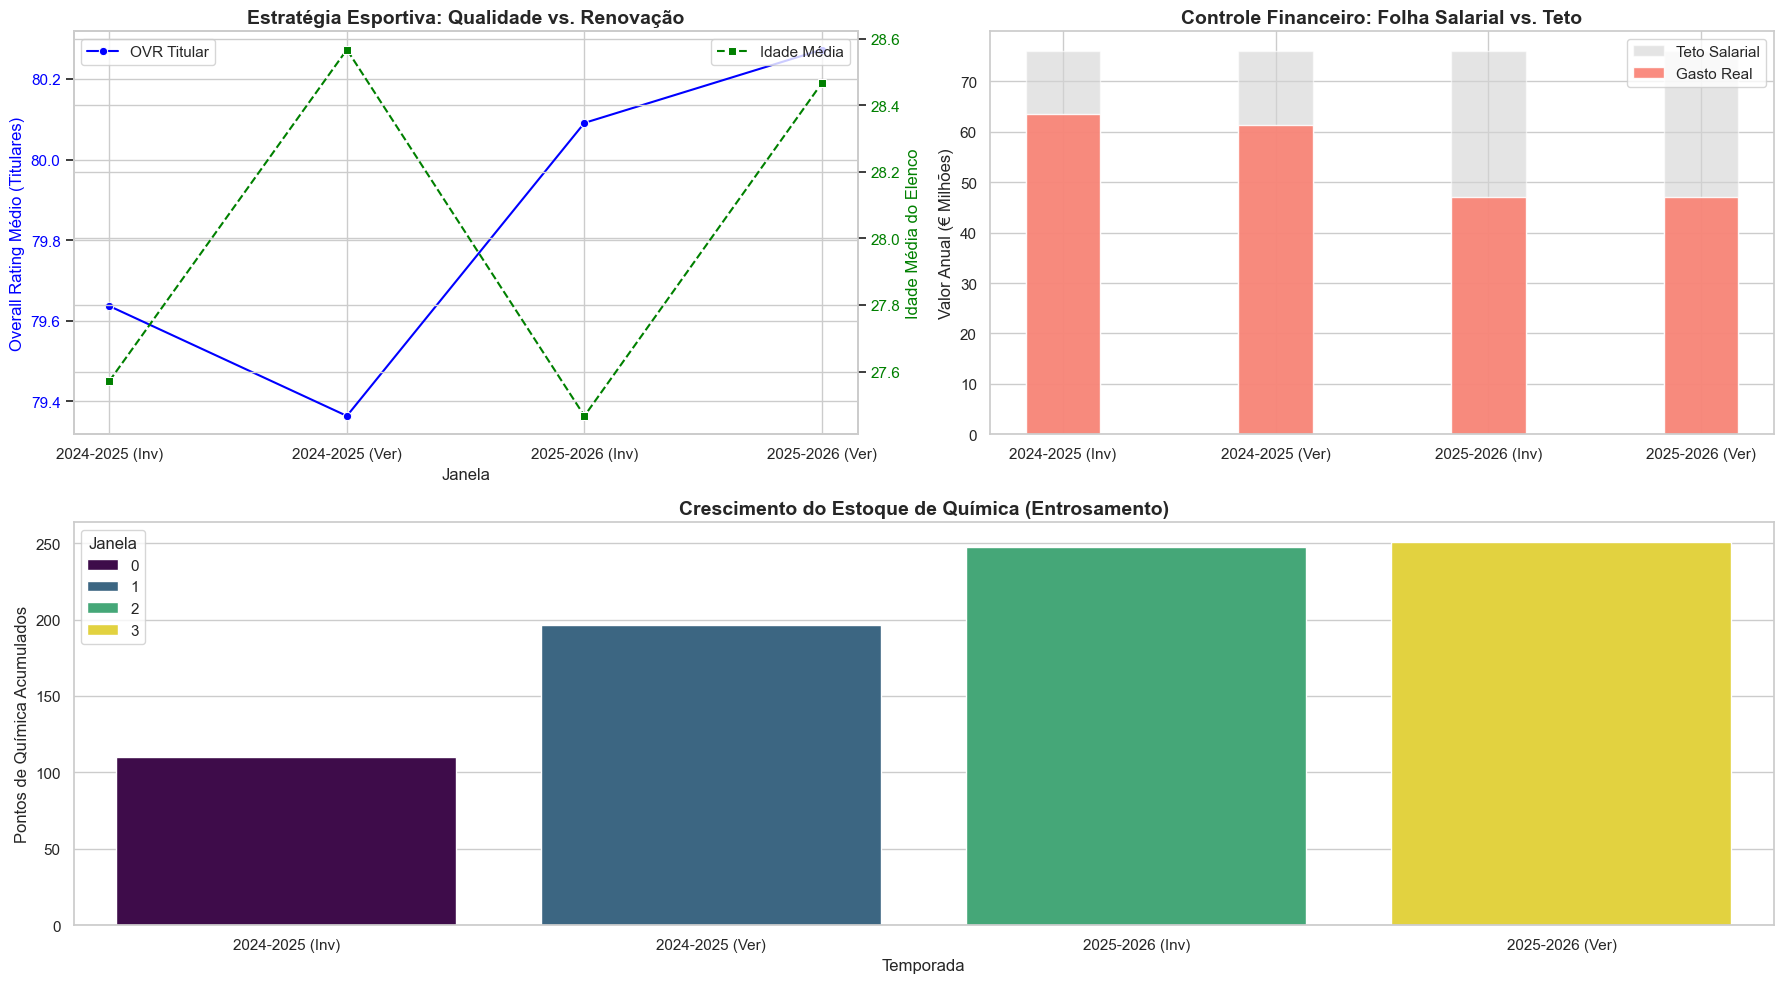

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- [PIPELINE DE VISUALIZAÇÃO] ---

def gerar_graficos_resultados():
    if pulp.LpStatus[model.status] != 'Optimal' and pulp.LpStatus[model.status] != 'Undefined':
        print("O modelo não foi resolvido. Pule esta etapa.")
        return

    # 1. Extração de Dados do Solver para DataFrame
    dados_grafico = []
    
    for t in JANELAS:
        # Jogadores no elenco em t
        elenco_t_ids = [i for i in todos_os_ids 
                       if no_elenco_vars[i, t].varValue is not None and no_elenco_vars[i, t].varValue > 0.9]
        
        # Titulares em t
        titulares_t_ids = [i for i in todos_os_ids 
                          if titular_vars[i, t].varValue is not None and titular_vars[i, t].varValue > 0.9]
        
        # Estatísticas Agregadas
        ovr_medio_titular = np.mean([dados_temporais[i][t]['overall_rating'] for i in titulares_t_ids])
        idade_media = np.mean([dados_temporais[i][t]['age'] for i in elenco_t_ids])
        folha_salarial = sum([dados_temporais[i][t]['wage_eur'] * 52 for i in elenco_t_ids])
        
        # Química Total
        quimica_total = 0
        for (i, j) in pares_relevantes:
             if Quimica[(i, j, t)].varValue:
                 quimica_total += Quimica[(i, j, t)].varValue
        
        dados_grafico.append({
            'Janela': t,
            'Temporada': f"{2024 + t//2}-{2025 + t//2} ({'Inv' if t%2==0 else 'Ver'})",
            'OVR Titular': ovr_medio_titular,
            'Idade Média': idade_media,
            'Folha Salarial (€M)': folha_salarial,
            'Teto Salarial (€M)': WAGE_BUDGET_YEAR,
            'Química Total': quimica_total
        })
    
    df_res = pd.DataFrame(dados_grafico)

    # --- CONFIGURAÇÃO DO ESTILO ---
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    # GRÁFICO 1: Evolução Técnica (Qualidade vs Idade)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(data=df_res, x='Janela', y='OVR Titular', marker='o', color='blue', label='OVR Titular', ax=ax1)
    ax1.set_ylabel('Overall Rating Médio (Titulares)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    sns.lineplot(data=df_res, x='Janela', y='Idade Média', marker='s', color='green', linestyle='--', label='Idade Média', ax=ax2)
    ax2.set_ylabel('Idade Média do Elenco', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.set_title('Estratégia Esportiva: Qualidade vs. Renovação', fontsize=14, fontweight='bold')
    ax1.set_xticks(df_res['Janela'])
    ax1.set_xticklabels(df_res['Temporada'])

    # GRÁFICO 2: Saúde Financeira
    ax3 = fig.add_subplot(gs[0, 1])
    
    # Plotando Teto e Gasto
    bar_width = 0.35
    index = df_res['Janela']
    
    ax3.bar(index, df_res['Teto Salarial (€M)'], bar_width, label='Teto Salarial', color='lightgray', alpha=0.6)
    ax3.bar(index, df_res['Folha Salarial (€M)'], bar_width, label='Gasto Real', color='salmon', alpha=0.9)
    
    ax3.set_title('Controle Financeiro: Folha Salarial vs. Teto', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Valor Anual (€ Milhões)')
    ax3.set_xticks(index)
    ax3.set_xticklabels(df_res['Temporada'])
    ax3.legend()

    # GRÁFICO 3: Evolução da Química
    ax4 = fig.add_subplot(gs[1, :]) # Ocupa a largura inteira embaixo
    sns.barplot(data=df_res, x='Temporada', y='Química Total', hue='Janela', palette='viridis', ax=ax4)
    ax4.set_title('Crescimento do Estoque de Química (Entrosamento)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Pontos de Química Acumulados')
    
    plt.tight_layout()
    plt.show()
    
# Chama a função
gerar_graficos_resultados()